In [ ]:
# pip install ydata_profiling

# Reading data and make them ready to work

In [1]:
import pandas as pd
# from ydata_profiling import ProfileReport

donor_df = pd.read_csv("BenefactorsData.csv")
# donor_profile = ProfileReport(donor_df, title = "Donors Data")
# donor_profile.to_file("Donors Data Profile.html")

payment_df = pd.read_csv("TransactionalData.csv")
# payment_profile = ProfileReport(payment_df, title = "Payments Transactions")
# payment_profile.to_file("Payments Data Profile.html")

In [ ]:
# donor_df.info()
# payment_df.info()

Merge summary of payments to donor dataset

In [3]:
merged_df = pd.merge(donor_df, payment_df, on="UserID")
merged_df.to_csv("merged_dataset.csv")

Add supplementary data to donor_df

In [11]:
# Calculate the number of records and sum of payments for each UserID in the Payment dataset
payment_summary = payment_df.groupby('UserID').agg(
    NumPayments=('TransID', 'count'),
    TotalPayment=('PaymentAmount', 'sum')
).reset_index()

# Merge the summary back into the Donor dataset
donor_df = donor_df.merge(payment_summary, on='UserID', how='left')
# Add a column to hold BirthYear
donor_df['BirthYear'] = int(0) if donor_df['BirthDate'] is None else donor_df['BirthDate'].str[:4].astype('Int64')
# Only keep rows with 1300 <=BirthYears < 1395
donor_df = donor_df[(donor_df['BirthYear'] <= 1395) & (donor_df['BirthYear'] >= 1300)]

# Extract the month from PaymentDate
payment_df['Month'] = int(0) if payment_df['PaymentDate'] is None else payment_df['PaymentDate'].str[5:7].astype('Int64')

# Group by Month and summarize NumPayments and TotalPayments
summary_by_month = payment_df.groupby('Month').agg({
    'TransID': 'count',  # Number of payments
    'PaymentAmount': 'sum'  # Total payments
}).reset_index()

# Rename columns name
summary_by_month.rename(columns={'TransID': 'NumPayments', 'PaymentAmount': 'TotalPayments'}, inplace=True)

# Filter out rows where Month is '00' for presentation
summary_by_month_filtered = summary_by_month.query("Month != 0")

# Group by SupportType and calculate number of payments and total payments
summary_dataset = payment_df.groupby('SupportType').agg({
    'TransID': 'count',  # Number of payments
    'PaymentAmount': 'sum'  # Total payments
}).reset_index()

# Rename columns name
summary_dataset.rename(columns={'TransID': 'NumberOfPayments', 'PaymentAmount': 'TotalPayments'}, inplace=True)

#print(summary_dataset)
#print(donor_df)

# Check the dependency between Gender and number of payments and total payments

In [12]:
# Find the 10 greatest values for NumPayments
top_num_payments = donor_df.nlargest(20, 'NumPayments')
print("Top 10 NumPayments:")
print(top_num_payments)

# Find the 10 greatest values for TotalPayment
top_total_payments = donor_df.nlargest(20, 'TotalPayment')
print("\nTop 10 TotalPayment:")
print(top_total_payments)

Top 10 NumPayments:
        UserID Gender                State   BirthDate ReferralSource  \
111497   74953     زن                تهران  1356-09-22        Website   
167849  173166    مرد             مازندران  1356-11-28    Application   
152975  144823    مرد  چهار محال و بختیاری  1363-05-19    Application   
50051   146387     زن               اصفهان  1364-06-30    Application   
43076   105131    مرد                تهران  1346-11-16        Unknown   
45461   112602    مرد                تهران  1361-06-24        Website   
151771  142764    مرد                تهران  1349-03-23    Application   
167719  172948    مرد                تهران  1371-01-13    Application   
152480  143912    مرد                تهران  1351-04-01        Unknown   
172768  181026     زن                تهران  1361-11-16        Website   
162202  162703    مرد                تهران  1354-11-27    Application   
49872   144807    مرد                 فارس  1351-02-25       Agencies   
171297  178694     زن          

In [13]:
from scipy.stats import ttest_ind
import numpy as np

# Remove nan values
donor_df = donor_df.dropna(subset=['Gender', 'NumPayments', 'TotalPayment'])

# Show number of payments and total payments by gender
male_data = donor_df[donor_df['Gender'] == 'مرد']
female_data = donor_df[donor_df['Gender'] == 'زن']
num_payments_test = ttest_ind(male_data['NumPayments'], female_data['NumPayments'], equal_var=False)
total_payment_test = ttest_ind(male_data['TotalPayment'], female_data['TotalPayment'], equal_var=False)

# Print results
print("T-test for NumPayments (Gender Dependency):")
print(f"Statistic: {num_payments_test.statistic}, p-value: {num_payments_test.pvalue}")

print("\nT-test for TotalPayment (Gender Dependency):")
print(f"Statistic: {total_payment_test.statistic}, p-value: {total_payment_test.pvalue}")

# Result:
# T-test for NumPayments (Gender Dependency):
# Statistic: 20.404277170355236, p-value: 1.8268465392917694e-92
# T-test for TotalPayment (Gender Dependency):
# Statistic: 4.543933993934602, p-value: 5.524716571142883e-06
# There is a significant relationship between gender and NumPayments
# There is a significant relationship between gender and TotalPayment

T-test for NumPayments (Gender Dependency):
Statistic: 20.570785728887735, p-value: 6.353878352222907e-94

T-test for TotalPayment (Gender Dependency):
Statistic: 4.680449173483, p-value: 2.864515305196179e-06


# Visualize the result

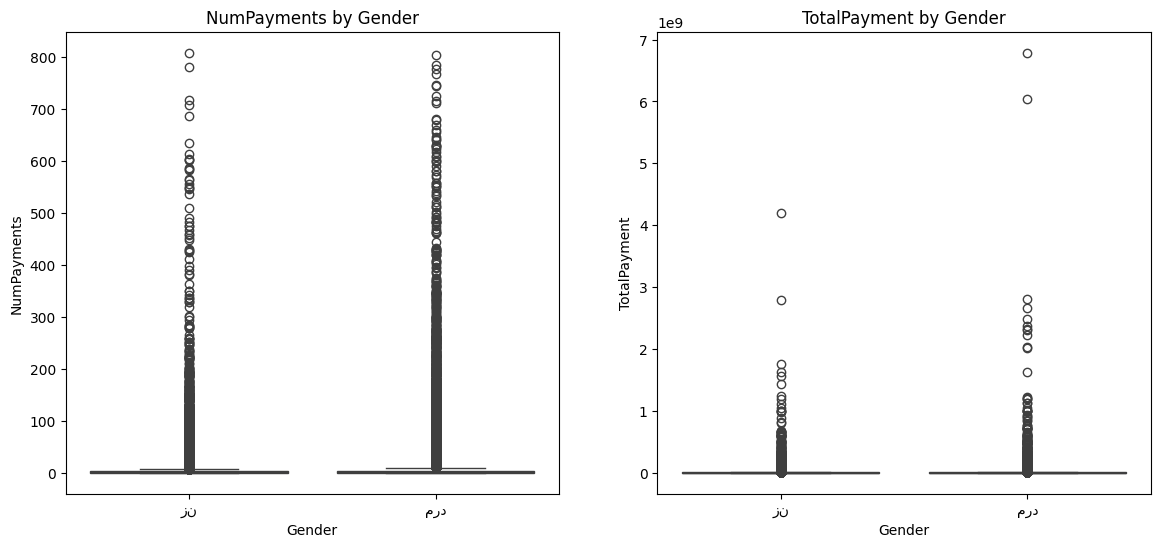

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for NumPayments by Gender
sns.boxplot(data=donor_df, x='Gender', y='NumPayments', ax=axes[0])
axes[0].set_title("NumPayments by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("NumPayments")

# Boxplot for TotalPayment by Gender
sns.boxplot(data=donor_df, x='Gender', y='TotalPayment', ax=axes[1])
axes[1].set_title("TotalPayment by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("TotalPayment")

# Show the plots
#plt.tight_layout()
plt.show()

In [14]:
# Group by Gender and calculate the mean of NumPayments and TotalPayment
group_stats = donor_df.groupby('Gender').agg({
    'NumPayments': 'mean',
    'TotalPayment': 'mean'
}).reset_index()

print(group_stats)

  Gender  NumPayments  TotalPayment
0     زن     4.957450  5.084182e+06
1    مرد     6.654981  5.775885e+06


# Profiling donor's characteristics based on different variables

In [24]:
# Helper function to create pie charts
def plot_pie_chart(data, column, values, title, colors=None):
    plt.figure(figsize=(8, 8))
    plt.pie(
        data[values],
        labels=data[column],
        autopct='%1.1f%%',
        startangle=140,
        colors=colors
    )
    plt.title(title)
    plt.show()

In [ ]:
# def plot_pie_chart(data, column, values, title, colors=None):
#     plt.figure(figsize=(8, 8))
    
#     # Create the pie chart
#     wedges, texts, autotexts = plt.pie(
#         data[values],
#         startangle=140,
#         colors=colors,
#         autopct='%1.1f%%'  # For percentages
#     )
    
#     # Add annotations for labels
#     for i, wedge in enumerate(wedges):
#         angle = (wedge.theta2 + wedge.theta1) / 2  # Midpoint of the wedge angle
#         x = 1.1 * wedge.r * plt.cos(angle * plt.pi / 180)  # Adjusting distance for annotation
#         y = 1.1 * wedge.r * plt.sin(angle * plt.pi / 180)
#         plt.text(x, y, data[column].iloc[i], ha='center', fontsize=10, color='black')

#     plt.title(title)
#     plt.show()


In [ ]:
# import numpy as np  # For trigonometric calculations

# def plot_pie_chart(data, column, values, title, colors=None):
#     plt.figure(figsize=(8, 8))
    
#     # Create the pie chart
#     wedges, _, autotexts = plt.pie(
#         data[values],
#         startangle=140,
#         colors=colors,
#         autopct='%1.1f%%'  # Show percentages in chart
#     )
    
#     # Annotate pie chart slices with labels (column values)
#     for i, wedge in enumerate(wedges):
#         # Calculate the angle for the label
#         angle = (wedge.theta2 + wedge.theta1) / 2
#         x = np.cos(np.deg2rad(angle)) * 1.4  # Adjust distance for the label
#         y = np.sin(np.deg2rad(angle)) * 1.4
#         plt.text(x, y, data[column].iloc[i], ha='center', fontsize=10, color='black')

#     plt.title(title)
#     plt.show()


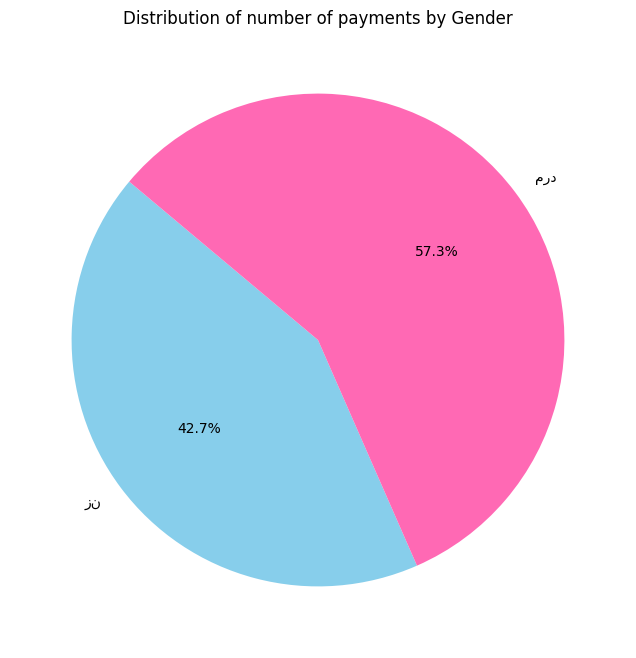

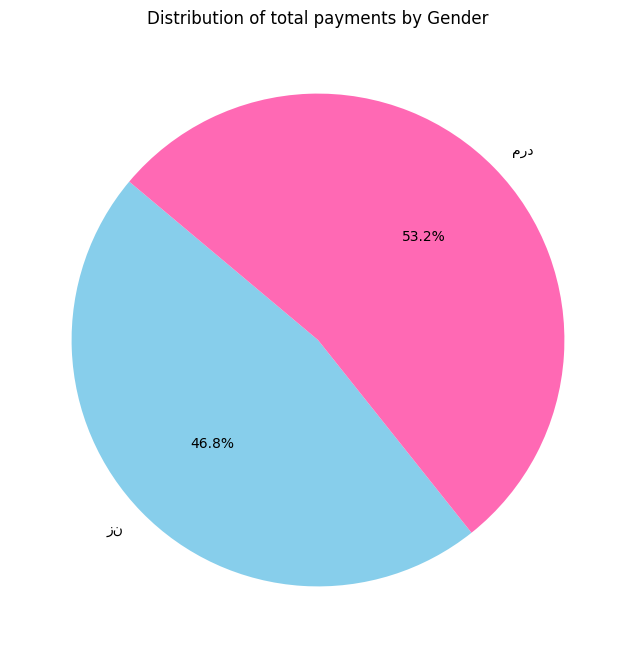

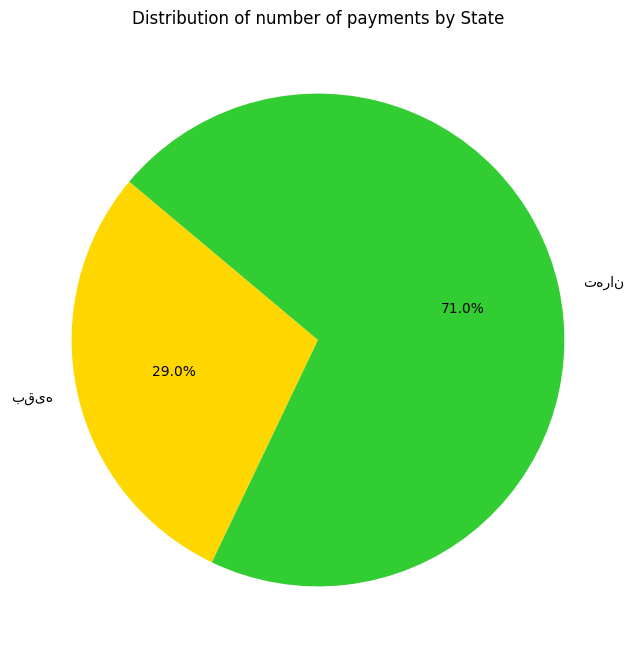

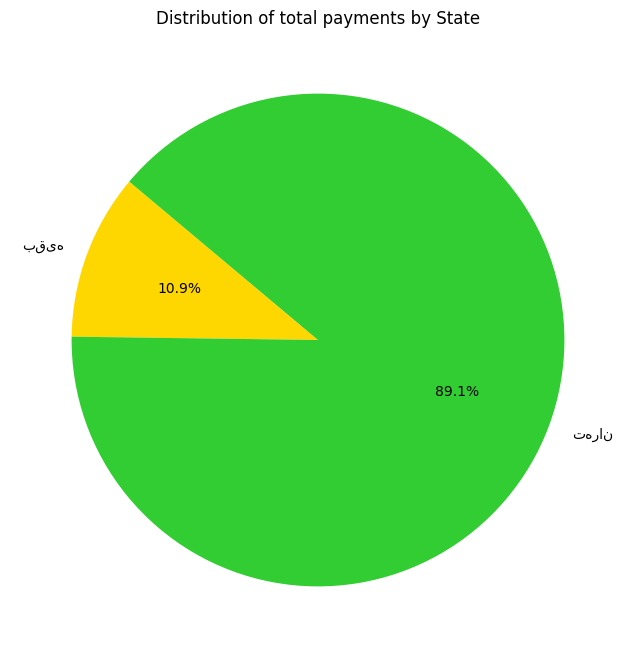

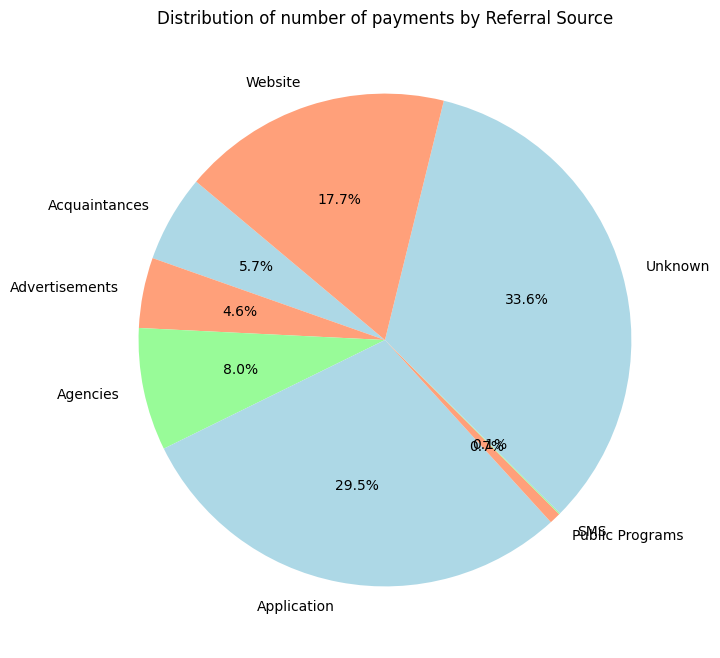

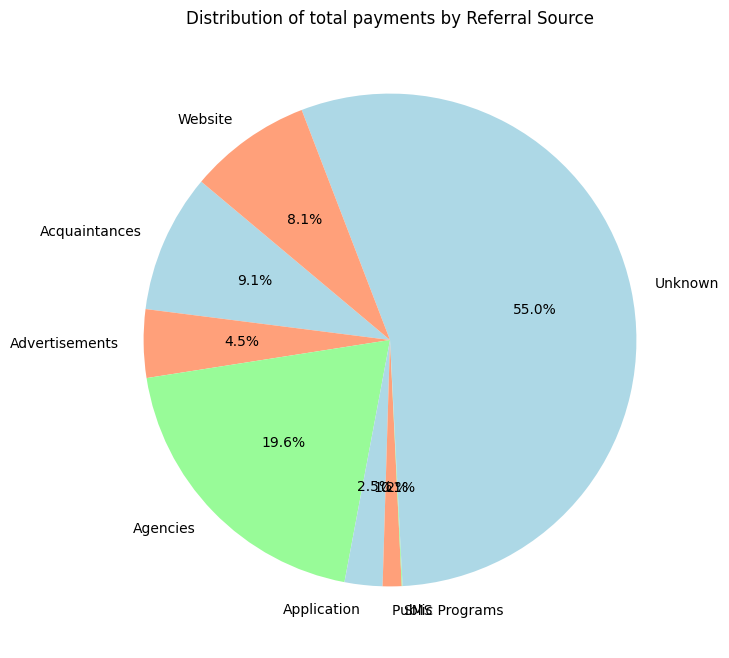

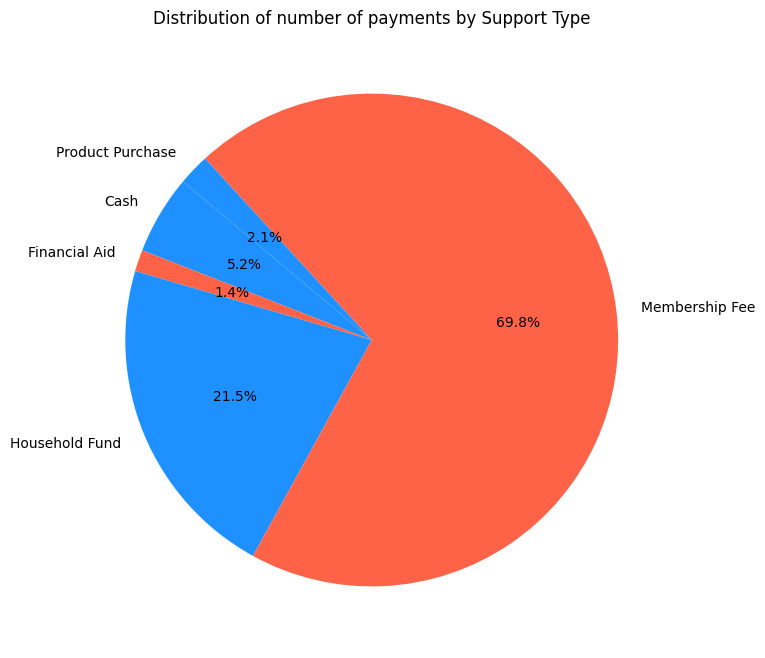

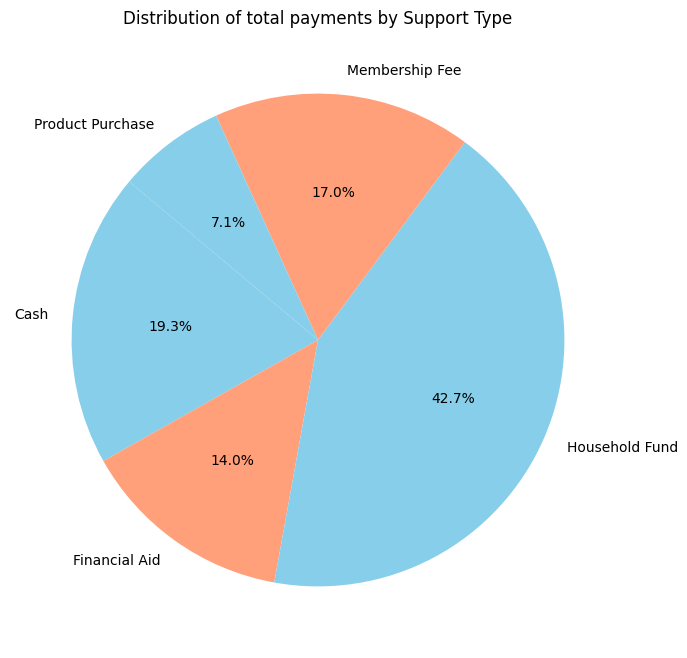

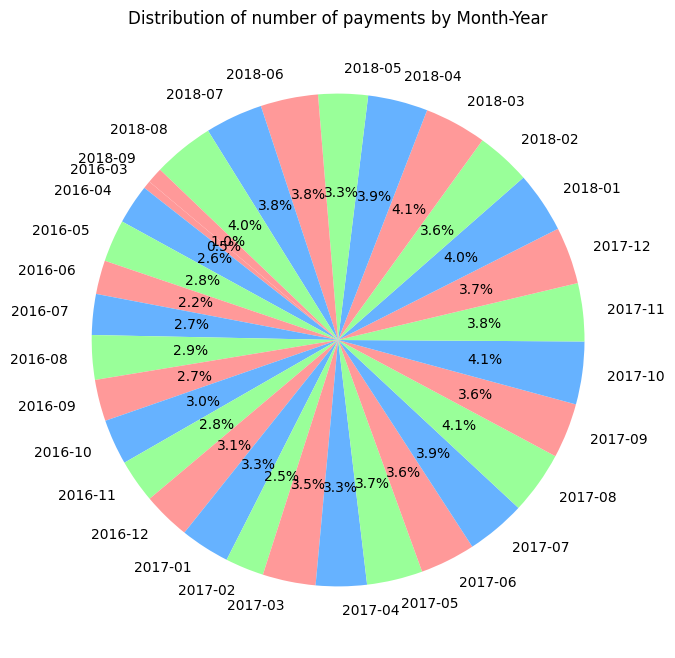

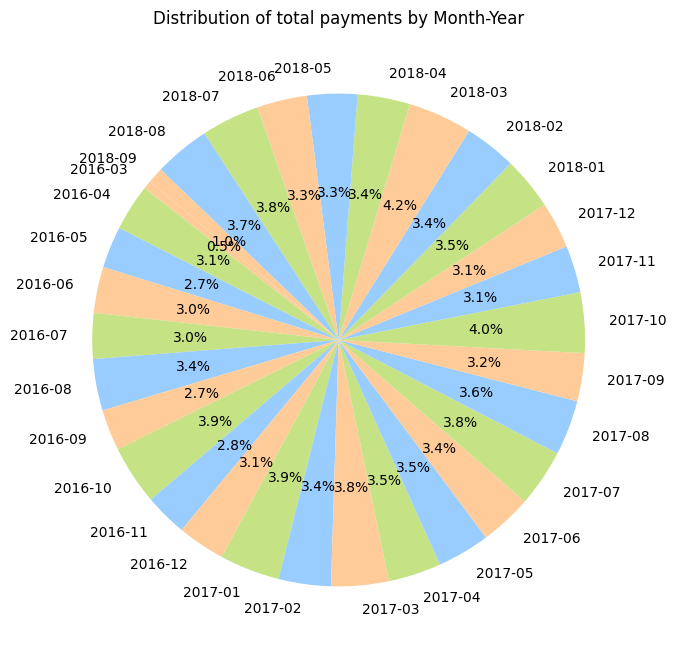

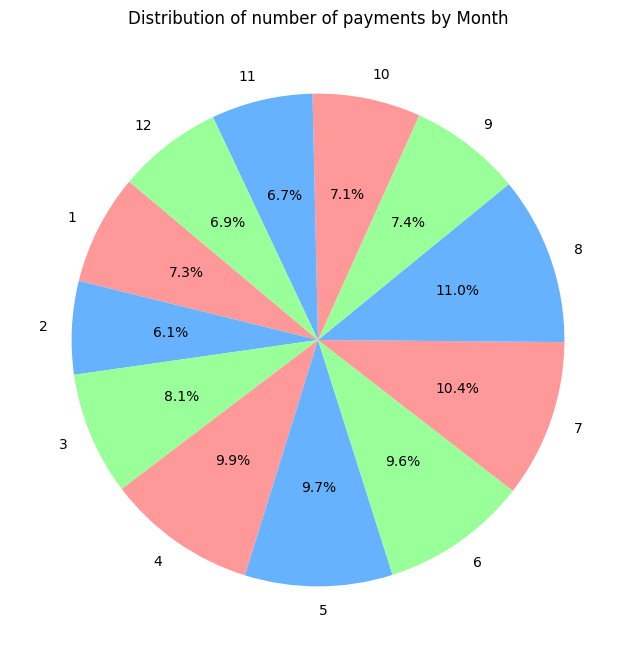

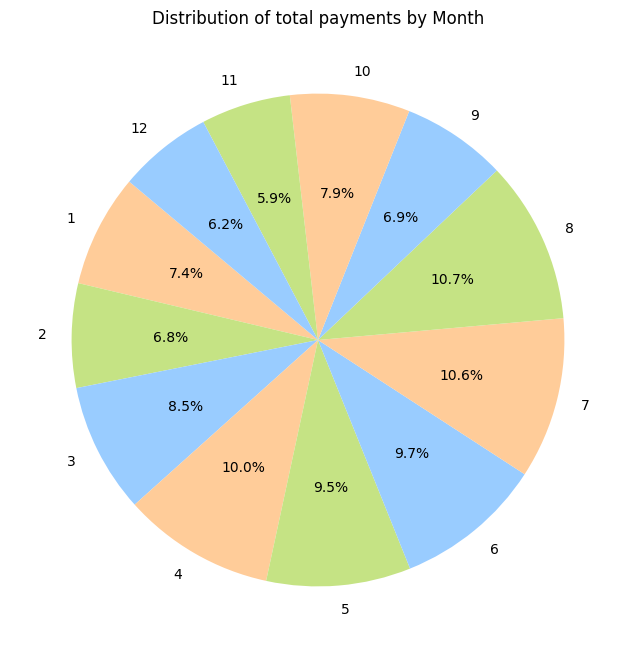

In [25]:
# Profiling: Gender statistics
gender_profile = donor_df.groupby('Gender').agg({
    'NumPayments': 'mean',
    'TotalPayment': 'mean'
}).reset_index()

# Profiling: State statistics
tehran_state = 'تهران'

# Create a new column to categorize into 'State1' and 'Others'
donor_df['StateCategory'] = donor_df['State'].apply(lambda x: 'تهران' if x == tehran_state else 'بقیه')

# Summarize the dataset by the new StateCategory
state_profile = donor_df.groupby('StateCategory').agg({
    'NumPayments': 'sum',
    'TotalPayment': 'sum'
}).reset_index()

# Profiling: Referral Source
Refer_profile = donor_df.groupby('ReferralSource').agg({
    'NumPayments': 'sum',
    'TotalPayment': 'sum'
}).reset_index()

# Convert PaymentDate to datetime format
payment_df['PaymentDate'] = pd.to_datetime(payment_df['PaymentDate'])
payment_df['MonthYear'] = payment_df['PaymentDate'].dt.strftime('%Y-%m')

# Group by Month-Year and summarize NumPayments and TotalPayments
summary_by_month_year = payment_df.groupby('MonthYear').agg({
    'TransID': 'count',  # Number of payments
    'PaymentAmount': 'sum'  # Total payments
}).reset_index()

# Rename columns name
summary_by_month_year.rename(columns={'TransID': 'NumPayments', 'PaymentAmount': 'TotalPayments'}, inplace=True)

# Plotting Number of Payments by Gender (Pie Chart)
plot_pie_chart(
    data=gender_profile,
    column='Gender',
    values='NumPayments',
    title='Distribution of number of payments by Gender',
    colors=['#87CEEB', '#FF69B4']  # Male: Blue, Female: Pink
)

plot_pie_chart(
    data=gender_profile,
    column='Gender',
    values='TotalPayment',
    title='Distribution of total payments by Gender',
    colors=['#87CEEB', '#FF69B4']
)

plot_pie_chart(
    data=state_profile,
    column='StateCategory',
    values='NumPayments',
    title='Distribution of number of payments by State',
    colors=['#FFD700', '#32CD32', '#FF4500']  # Gold, Green, Orange
)

plot_pie_chart(
    data=state_profile,
    column='StateCategory',
    values='TotalPayment',
    title='Distribution of total payments by State',
    colors=['#FFD700', '#32CD32', '#FF4500'] # Gold, Green, Orange
)

plot_pie_chart(
    data=Refer_profile,
    column='ReferralSource',
    values='NumPayments',
    title='Distribution of number of payments by Referral Source',
    colors=['#ADD8E6', '#FFA07A', '#98FB98']  # Light Blue, Salmon, Light Green
)

plot_pie_chart(
    data=Refer_profile,
    column='ReferralSource',
    values='TotalPayment',
    title='Distribution of total payments by Referral Source',
    colors=['#ADD8E6', '#FFA07A', '#98FB98']
)

# Visualizing Number of Payments by SupportType
plot_pie_chart(
    data=summary_dataset,
    column='SupportType',
    values='NumberOfPayments',
    title='Distribution of number of payments by Support Type',
    colors=['#1E90FF', '#FF6347']  # Blue for Recurring, Red for One-time
)

# Visualizing Total Payments by SupportType
plot_pie_chart(
    data=summary_dataset,
    column='SupportType',
    values='TotalPayments',
    title='Distribution of total payments by Support Type',
    colors=['#87CEEB', '#FFA07A']  # Light Blue for Recurring, Light Salmon for One-time
)

# Pie chart for NumPayments by MonthYear
plot_pie_chart(
    data=summary_by_month_year,
    column='MonthYear',
    values='NumPayments',
    title='Distribution of number of payments by Month-Year',
    colors=['#FF9999', '#66B2FF', '#99FF99']  # Custom colors for each month
)

# Pie chart for TotalPayments by MonthYear
plot_pie_chart(
    data=summary_by_month_year,
    column='MonthYear',
    values='TotalPayments',
    title='Distribution of total payments by Month-Year',
    colors=['#FFCC99', '#C5E384', '#99CCFF']  # Custom colors for each month
)

# Pie chart for NumPayments by Month
plot_pie_chart(
    data=summary_by_month,
    column='Month',
    values='NumPayments',
    title='Distribution of number of payments by Month',
    colors=['#FF9999', '#66B2FF', '#99FF99']  # Custom colors for each month
)

# Pie chart for TotalPayments by Month
plot_pie_chart(
    data=summary_by_month,
    column='Month',
    values='TotalPayments',
    title='Distribution of total payments by Month',
    colors=['#FFCC99', '#C5E384', '#99CCFF']  # Custom colors for each month
)